## FFTW playground - examples of usage of the pyFFTW library

In [1]:
%matplotlib inline 
import os 
from timeit import Timer
import numpy as np
import scipy.signal
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

import pyfftw
from pyfftw.interfaces import numpy_fft, scipy_fftpack
print('OMP_NUM_THREADS', os.environ.get('OMP_NUM_THREADS'))
print('MKL_NUM_THREADS', os.environ.get('MKL_NUM_THREADS'))
pyfftw.config.NUM_THREADS=4
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'
pyfftw.interfaces.cache.enable()

print(pyfftw.__file__)

OMP_NUM_THREADS 4
MKL_NUM_THREADS None
/Users/matteoravasi/anaconda/envs/pylopsfftw/lib/python3.7/site-packages/pyfftw/__init__.py


In [2]:
# Monkey patching np.fft
#try:
#    import pyfftw
#    np.fft = pyfftw.interfaces.numpy_fft
#except:
#    pyfftw=None

### Use numpy.fft interface

In [3]:
# Generate some data
n = 2**10
dt = 0.001
f0 = 20
t = np.arange(n)*dt
f = pyfftw.interfaces.numpy_fft.fftfreq(n,d=dt)
ar = np.sin(2*np.pi*f0*t)

FFT->IFFT same input: False


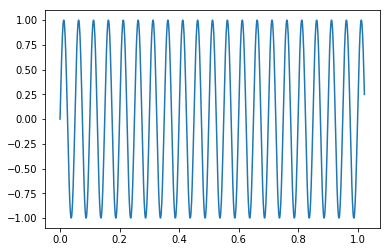

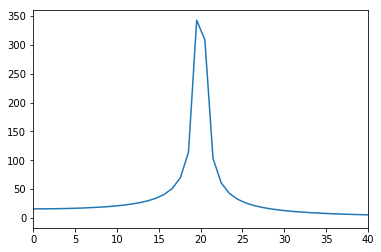

In [4]:
a = pyfftw.empty_aligned(n, dtype='complex128', n=pyfftw.simd_alignment)
a[:] = ar + 1j*np.zeros(n)
b = np.fft.fft(a)
c = pyfftw.interfaces.numpy_fft.fft(a)

print('FFT->IFFT same input:', np.allclose(a, c))

plt.figure()
plt.plot(t, ar)

plt.figure()
plt.plot(f[:n//2], np.abs(b)[:n//2])
plt.xlim(0,40);

### Use basic FFTW interface

FFT->IFFT same input: True


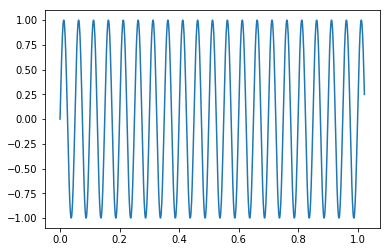

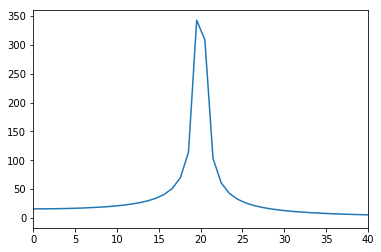

In [5]:
a = pyfftw.empty_aligned(n, dtype='complex128')
b = pyfftw.empty_aligned(n, dtype='complex128')
c = pyfftw.empty_aligned(n, dtype='complex128')

fft_object = pyfftw.FFTW(a, b, threads=4)
ifft_object = pyfftw.FFTW(b, c, direction='FFTW_BACKWARD', threads=4)

# Generate some data
dt = 0.001
f0 = 20
t = np.arange(n)*dt
f = pyfftw.interfaces.numpy_fft.fftfreq(n,d=dt)
ar = np.sin(2*np.pi*f0*t)
a[:] = ar + 1j*np.zeros(n)

fft_object()
ifft_object()
print('FFT->IFFT same input:', np.allclose(a, c))

plt.figure()
plt.plot(t, ar)

plt.figure()
plt.plot(f[:n//2], np.abs(b)[:n//2])
plt.xlim(0,40);

With real data

FFT->IFFT same input: True


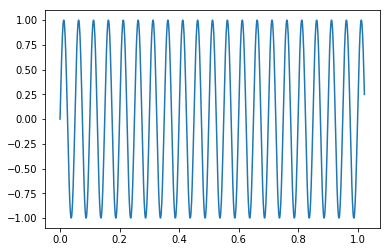

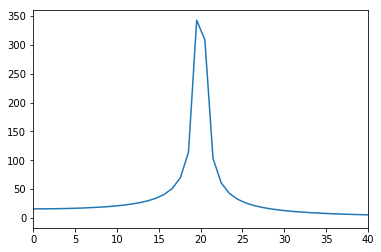

In [6]:
a = pyfftw.empty_aligned(n, dtype='float64')
b = pyfftw.empty_aligned(n//2 +1, dtype='complex128')
c = pyfftw.empty_aligned(n, dtype='float64')

fft_object = pyfftw.FFTW(a, b, threads=4)
ifft_object = pyfftw.FFTW(b, c, direction='FFTW_BACKWARD', threads=4)

# Generate some data
dt = 0.001
f0 = 20
t = np.arange(n)*dt
f = pyfftw.interfaces.numpy_fft.fftfreq(n,d=dt)
ar = np.sin(2*np.pi*f0*t)
a[:] = ar + 1j*np.zeros(n)

fft_object()
ifft_object()
print('FFT->IFFT same input:', np.allclose(a, c))

plt.figure()
plt.plot(t, ar)

plt.figure()
plt.plot(f[:n//2], np.abs(b)[:n//2])
plt.xlim(0,40);

### Compare scipy with pyfftw convolve straigh from pyFFTW documentation

In [7]:
a = pyfftw.empty_aligned((1024, 64), dtype='complex128')
b = pyfftw.empty_aligned((1024, 64), dtype='complex128')

a[:] = np.random.randn(1024, 64) + 1j*np.random.randn(1024, 64)
b[:] = np.random.randn(1024, 64) + 1j*np.random.randn(1024, 64)

print(scipy.fftpack)
t = Timer(lambda: scipy.signal.fftconvolve(a, b))

print('Time with scipy.fftpack: %1.3f seconds' % t.timeit(number=100))

# Configure PyFFTW to use all cores (the default is single-threaded)
pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
print('NUM_THREADS:', pyfftw.config.NUM_THREADS)

# Monkey patch fftpack with pyfftw.interfaces.scipy_fftpack
scipy.fftpack = pyfftw.interfaces.scipy_fftpack
print(scipy.fftpack)
t = Timer(lambda: scipy.signal.fftconvolve(a, b))

# Turn on the cache for optimum performance
pyfftw.interfaces.cache.enable()

print('Time with monkey patched scipy_fftpack: %1.3f seconds' %
       t.timeit(number=100))

<module 'scipy.fftpack' from '/Users/matteoravasi/anaconda/envs/pylopsfftw/lib/python3.7/site-packages/scipy/fftpack/__init__.py'>
Time with scipy.fftpack: 6.888 seconds
NUM_THREADS: 4
<module 'pyfftw.interfaces.scipy_fftpack' from '/Users/matteoravasi/anaconda/envs/pylopsfftw/lib/python3.7/site-packages/pyfftw/interfaces/scipy_fftpack.py'>
Time with monkey patched scipy_fftpack: 6.489 seconds
